# Recitation 2: Collision checking between convex polygons



## Activate your python environment

`conda activate cs460`



## Determine the collision
Collision detection is a foundational technique in robotics, computer graphics, and game development. It identifies when two or more objects intersect or come into contact. For convex polygons, various efficient methods have been developed to ascertain if they overlap. This session will explore the fundamental mechanisms behind convex polygon collision detection.

## Convex vs Concave
<img src="image.png" width="50%">

### Convex Polygons:
A polygon is termed as convex if no line segment drawn between any two points of the polygon lies outside the polygon. In other words, all the interior angles of the polygon are less than or equal to $\pi / 2$.

### Concave Polygons:
Conversely, a polygon is termed as concave if at least one line segment drawn between two points of the polygon falls outside the polygon. This implies that at least one interior angle of the polygon is greater than $\pi / 2$.
 
Concave are not considered in this course. To deal with collision checking on concave polygon, we will normally do decomposition first. Ref: https://github.com/kmammou/v-hacd

## 1. Broad-phase Collision Detection
This quickly identifies pairs of objects that might be colliding. The goal here isn't accuracy but efficiency.

* Bounding Boxes: Objects are enclosed in simple shapes like rectangles (AABB - Axis-Aligned Bounding Box) or circles. If these simple shapes don't overlap, the objects inside them don't either.

* Spatial Partitioning: The environment is divided into cells or partitions. Only objects within the same cell or adjacent cells are checked for collisions.

Bounding Boxes example:

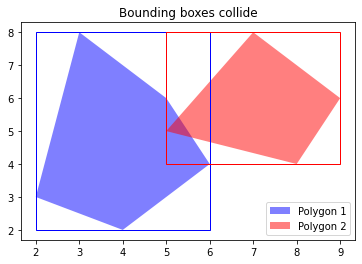

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define two polygons
polygon1 = np.array([[2, 3], [3, 8], [5, 6], [6, 4], [4, 2]])
polygon2 = np.array([[5, 5], [7, 8], [9, 6], [8, 4]])

# Calculate bounding boxes
min1, max1 = np.min(polygon1, axis=0), np.max(polygon1, axis=0)
min2, max2 = np.min(polygon2, axis=0), np.max(polygon2, axis=0)

# Check if bounding boxes collide
collide_x = min1[0] < max2[0] and max1[0] > min2[0]
collide_y = min1[1] < max2[1] and max1[1] > min2[1]
collide = collide_x and collide_y

# Visualization
fig, ax = plt.subplots()

# Draw polygons
ax.fill(polygon1[:, 0], polygon1[:, 1], 'b', label='Polygon 1', alpha=0.5)
ax.fill(polygon2[:, 0], polygon2[:, 1], 'r', label='Polygon 2', alpha=0.5)

# Draw bounding boxes
rect1 = patches.Rectangle(min1, max1[0] - min1[0], max1[1] - min1[1], linewidth=1, edgecolor='b', facecolor='none')
rect2 = patches.Rectangle(min2, max2[0] - min2[0], max2[1] - min2[1], linewidth=1, edgecolor='r', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

ax.legend()

if collide:
    ax.set_title("Bounding boxes collide")
else:
    ax.set_title("Bounding boxes don't collide")

plt.show()


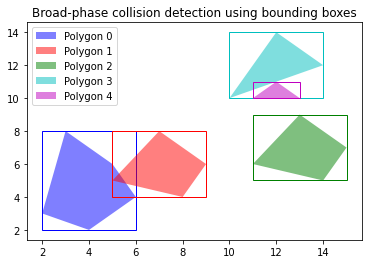

Colliding pairs (by ID): [(0, 1), (3, 4)]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define five polygons
polygons = [
    np.array([[2, 3], [3, 8], [5, 6], [6, 4], [4, 2]]),
    np.array([[5, 5], [7, 8], [9, 6], [8, 4]]),
    np.array([[11, 6], [13, 9], [15, 7], [14, 5]]),
    np.array([[10, 10], [12, 14], [14, 12]]),
    np.array([[11, 10], [12, 11], [13, 10]])
]

def check_collision(bbox1, bbox2):
    '''Check if two bounding boxes collide'''
    return not (bbox1[1][0] < bbox2[0][0] or 
                bbox1[0][0] > bbox2[1][0] or 
                bbox1[1][1] < bbox2[0][1] or 
                bbox1[0][1] > bbox2[1][1])

# Find bounding boxes
bounding_boxes = [np.array([np.min(polygon, axis=0), np.max(polygon, axis=0)]) for polygon in polygons]

# Check for collisions
colliding_pairs = []
for i in range(len(bounding_boxes)):
    for j in range(i+1, len(bounding_boxes)):
        if check_collision(bounding_boxes[i], bounding_boxes[j]):
            colliding_pairs.append((i, j))

# Visualization
fig, ax = plt.subplots()
colors = ['b', 'r', 'g', 'c', 'm']
labels = ['Polygon 0', 'Polygon 1', 'Polygon 2', 'Polygon 3', 'Polygon 4']

for idx, polygon in enumerate(polygons):
    ax.fill(polygon[:, 0], polygon[:, 1], colors[idx], label=labels[idx], alpha=0.5)
    min_coords, max_coords = bounding_boxes[idx]
    rect = patches.Rectangle(min_coords, max_coords[0] - min_coords[0], max_coords[1] - min_coords[1], 
                             linewidth=1, edgecolor=colors[idx], facecolor='none')
    ax.add_patch(rect)

ax.legend()
ax.set_title("Broad-phase collision detection using bounding boxes")

plt.show()

print("Colliding pairs (by ID):", colliding_pairs)



Spatial Partitioning Example:

What if we move Polygon 1 to the left a bit?

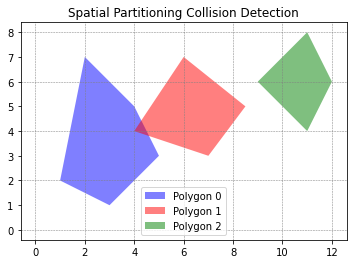

Colliding pairs (by ID): {(0, 1), (1, 2)}


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define three polygons
polygons = [
    np.array([[1, 2], [2, 7], [4, 5], [5, 3], [3, 1]]),
    np.array([[4, 4], [6, 7], [8.5, 5], [7, 3]]),
    np.array([[9, 6], [11, 8], [12, 6], [11, 4]])
]

# Grid configuration
grid_size = 2  # Size of each grid cell

def get_occupied_cells(polygon, grid_size):
    '''Return cells occupied by the polygon'''
    min_coords = np.min(polygon, axis=0)
    max_coords = np.max(polygon, axis=0)
    
    min_cell = np.floor(min_coords / grid_size).astype(int)
    max_cell = np.floor(max_coords / grid_size).astype(int)
    
    occupied_cells = []
    for i in range(min_cell[0], max_cell[0] + 1):
        for j in range(min_cell[1], max_cell[1] + 1):
            occupied_cells.append((i, j))
    
    return occupied_cells

# Map polygons to grid cells
grid = {}
for idx, polygon in enumerate(polygons):
    for cell in get_occupied_cells(polygon, grid_size):
        if cell not in grid:
            grid[cell] = []
        grid[cell].append(idx)

# Check for collisions based on grid occupancy
colliding_pairs = set()
for cell, occupants in grid.items():
    if len(occupants) > 1:
        for i in range(len(occupants)):
            for j in range(i+1, len(occupants)):
                colliding_pairs.add((occupants[i], occupants[j]))

# Visualization
fig, ax = plt.subplots()

colors = ['b', 'r', 'g']
labels = ['Polygon 0', 'Polygon 1', 'Polygon 2']

# Draw polygons
for idx, polygon in enumerate(polygons):
    ax.fill(polygon[:, 0], polygon[:, 1], colors[idx], label=labels[idx], alpha=0.5)

# Draw grid
max_coord = np.max([np.max(polygon, axis=0) for polygon in polygons], axis=0)
cols = int(np.ceil(max_coord[0] / grid_size))
rows = int(np.ceil(max_coord[1] / grid_size))

for i in range(cols + 1):
    plt.axvline(i * grid_size, color='gray', linestyle='--', linewidth=0.5)
for i in range(rows + 1):
    plt.axhline(i * grid_size, color='gray', linestyle='--', linewidth=0.5)

ax.legend()
ax.set_title("Spatial Partitioning Collision Detection")
ax.set_aspect('equal')

plt.show()

print("Colliding pairs (by ID):", colliding_pairs)


## 2. Separating Axis Theorem (SAT):
Once potential collisions are identified in the broad phase, we need a finer method to verify these. SAT is a popular method for convex polygon collision detection. SAT can only handle convex shapes, but this is OK because non-convex shapes can be represented by a combination of convex shapes. Ref: https://dyn4j.org/2010/01/sat/

* Principle: If a line (or axis) exists such that the projections of two polygons onto this line do not overlap, then the polygons do not collide.
  
  <img src="image-2.png" width="28%" style="background-color: white;"> <img src="image-3.png" width="30.5%" style="background-color: white;">
  
* Implementation: For each edge of the two polygons, project both polygons onto the line perpendicular to the edge (normal). If there's any gap in any of the projections, the polygons do not collide.
* Steps:

  1. Find the Axes: For each edge of both polygons, compute the normal (perpendicular) vector. These are the axes you'll test for separation.
  2. Project the Polygons: For each axis, project both polygons onto that axis.
  3. Check for Non-overlapping Intervals: If, for any axis, the projections of the two polygons do not overlap, then the polygons do not collide.
  4. All Overlaps: If the projections of the polygons overlap on all axes, then the polygons collide.

An example of SAT will not work for concave polygon directly:

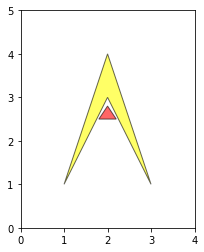

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_polygon(ax, polygon, color):
    """Helper function to plot a polygon."""
    polygon = patches.Polygon(polygon, closed=True, edgecolor='black', facecolor=color, alpha=0.6)
    ax.add_patch(polygon)

# Define a concave polygon (looks somewhat like the letter 'U')
concave_polygon = [
    (1, 1),
    (2, 4),
    (3, 1),
    (2.5, 2),
    (2, 3),
    (1.5, 2)
]

# Define a small convex polygon that lies inside the 'gap' of the concave polygon
convex_polygon = [
    (1.8, 2.5),
    (2.2, 2.5),
    (2, 2.8)
]

fig, ax = plt.subplots()
plot_polygon(ax, concave_polygon, 'yellow')
plot_polygon(ax, convex_polygon, 'red')

# Set up the plot
ax.set_aspect('equal', 'box')
ax.set_xlim(0, 4)
ax.set_ylim(0, 5)
plt.show()


## 3. Minkowski Sum for Collision Checking:
The Minkowski sum provides another geometric approach to collision detection, especially beneficial when dealing with motion planning.

* Minkowski Sum: For two sets A and B, the Minkowski sum is a new set derived by adding every vector in A to every vector in B.
* Application in Collision Detection: When one polygon is 'expanded' by another, if the origin lies within this Minkowski sum, the two polygons intersect.
* Minkowski Difference: A subset of the Minkowski sum, it's derived by subtracting every vector in B from every vector in A. If this difference contains the origin, then A and B overlap.

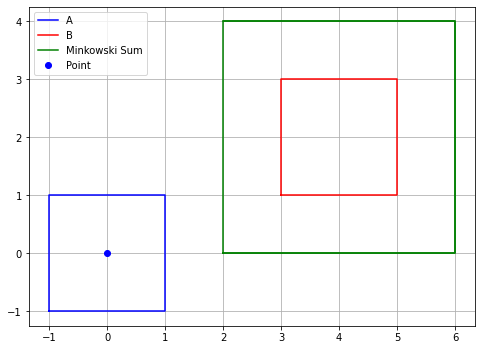

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


def visualize_polygons(A, B, S):
    """Visualize polygons A, B, and their Minkowski sum S."""
    plt.figure(figsize=(8, 8))

    plt.plot(np.append(A[:, 0], A[0, 0]), np.append(A[:, 1], A[0, 1]), label="A", color='blue')
    plt.plot(np.append(B[:, 0], B[0, 0]), np.append(B[:, 1], B[0, 1]), label="B", color='red')

    hull = ConvexHull(S)
    plt.plot(hull.points[hull.vertices, 0], hull.points[hull.vertices, 1], label="Minkowski Sum", color='green')
    plt.plot(np.append(hull.points[hull.vertices, 0], hull.points[hull.vertices[0], 0]), 
             np.append(hull.points[hull.vertices, 1], hull.points[hull.vertices[0], 1]), color='green')
    plt.plot(0, 0, 'bo', label='Point')

    plt.legend()
    plt.grid(True)
    ax = plt.gca()  # Get the current axes instance
    ax.set_aspect('equal')  # Set the aspect ratio of the plot
    plt.show()

A = np.array([[-1., -1.],
       [ 1., -1.],
       [ 1.,  1.],
       [-1.,  1.]])
B = np.array([[3., 1.],
       [5., 1.],
       [5., 3.],
       [3., 3.]])
S = np.array([[2., 0.],
       [4., 0.],
       [4., 2.],
       [2., 2.],
       [4., 0.],
       [6., 0.],
       [6., 2.],
       [4., 2.],
       [4., 2.],
       [6., 2.],
       [6., 4.],
       [4., 4.],
       [2., 2.],
       [4., 2.],
       [4., 4.],
       [2., 4.]])

visualize_polygons(A, B, S)


Image the square is a robot, what happens if it rotates a bit?